## Create Grid NetCDF from scratch

***Use the example from Stefan?***

To get the data of auxiliary coordinate variables, do the same as above, e.g. `ds['time_bnds'].data`. But imagine we have the coordinate data and wanna newly generate coordinates for boundary variables, we can generate it from the coordinates

### Example from Stefan

In [43]:
import os
from glob import glob
import matplotlib.pyplot as plt
plt.ioff()
import numpy as np
import pandas as pd
import xarray as xr

from datetime import timedelta, datetime
from cftime import date2num
from pyproj import Proj

In [2]:
inpath = "/Users/icdc/Documents/NFDI/Kemeng/publishable_netcdf/data"
file = os.path.join(inpath, "raw", "ESA-SICCI2_ICDC__SeaIceVolumeTimeseries__north_ao_v2.0_fv0.02.txt")
file

'/Users/icdc/Documents/NFDI/Kemeng/publishable_netcdf/data/raw/ESA-SICCI2_ICDC__SeaIceVolumeTimeseries__north_ao_v2.0_fv0.02.txt'

In [3]:
# Read ASCII Data
df = pd.read_csv(file, sep=";", comment="#", header=0, skiprows=6,
                 names=['date', 'sea_ice_volume_km3', 'sea_ice_volume_error_km3'])
df = df.set_index('date')

In [4]:
df.tail()

,sea_ice_volume_km3,sea_ice_volume_error_km3
date,,
201612,9736.58,3216.73
201701,11080.33,3701.67
201702,12188.66,4029.27
201703,13518.18,4401.98
201704,13943.92,4582.80


In [5]:
# Convert the data to xarray
dssiv = df.to_xarray()
dssiv

<xarray.Dataset> Size: 3kB
Dimensions:                   (date: 105)
Coordinates:
  * date                      (date) int64 840B 200210 200211 ... 201703 201704
Data variables:
    sea_ice_volume_km3        (date) float64 840B 6.474e+03 ... 1.394e+04
    sea_ice_volume_error_km3  (date) float64 840B 1.973e+03 ... 4.583e+03

In [6]:
# Create a continuous time dimension beginning at 2000-01-1 using an average number of days per year that includes a leap year
dssiv['date'] = 365.25 * ((np.round(dssiv['date']*0.01) + (dssiv['date']*0.01 - np.round(dssiv['date']*0.01))/0.12) - 2002.) + 2.0*365.25
dssiv.date

<xarray.DataArray 'date' (date: 105)> Size: 840B
array([1034.875 , 1065.3125, 1095.75  , 1126.1875, 1156.625 , 1187.0625,
       1217.5   , 1400.125 , 1430.5625, 1461.    , 1491.4375, 1521.875 ,
       1552.3125, 1582.75  , 1765.375 , 1795.8125, 1826.25  , 1856.6875,
       1887.125 , 1917.5625, 1948.    , 2130.625 , 2161.0625, 2191.5   ,
       2221.9375, 2252.375 , 2282.8125, 2313.25  , 2495.875 , 2526.3125,
       2556.75  , 2587.1875, 2617.625 , 2648.0625, 2678.5   , 2861.125 ,
       2891.5625, 2922.    , 2952.4375, 2982.875 , 3013.3125, 3043.75  ,
       3226.375 , 3256.8125, 3287.25  , 3317.6875, 3348.125 , 3378.5625,
       3409.    , 3591.625 , 3622.0625, 3652.5   , 3682.9375, 3713.375 ,
       3743.8125, 3774.25  , 3956.875 , 3987.3125, 4017.75  , 4048.1875,
       4078.625 , 4109.0625, 4139.5   , 4322.125 , 4352.5625, 4383.    ,
       4413.4375, 4443.875 , 4474.3125, 4504.75  , 4687.375 , 4717.8125,
       4748.25  , 4778.6875, 4809.125 , 4839.5625, 4870.    , 5052.625 ,
       5083.0625, 5113.5   , 5143.9375, 5174.375 , 5204.8125, 5235.25  ,
       5417.875 , 5448.3125, 5478.75  , 5509.1875, 5539.625 , 5570.0625,
       5600.5   , 5783.125 , 5813.5625, 5844.    , 5874.4375, 5904.875 ,
       5935.3125, 5965.75  , 6148.375 , 6178.8125, 6209.25  , 6239.6875,
       6270.125 , 6300.5625, 6331.    ])
Coordinates:
  * date     (date) float64 840B 1.035e+03 1.065e+03 ... 6.301e+03 6.331e+03

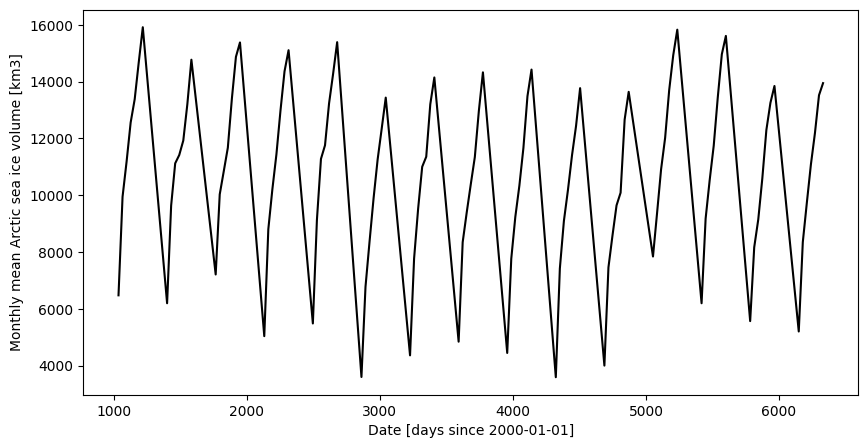

In [7]:
# How does the time series look like?
plt.figure(figsize=(10,5))
ax = dssiv['sea_ice_volume_km3'].plot(color='k')
ax = plt.xlabel("Date [days since 2000-01-01]", color = 'k')
ax = plt.ylabel('Monthly mean Arctic sea ice volume [km3]', color = 'k')
plt.show()

In [8]:
# Get DataArray of sea ice volume in km^3
siv = dssiv.sea_ice_volume_km3.data
# Convert the sea ice volume to m^3 (SI units)
siv = siv * 1e6
#print(siv)

siv_error = dssiv.sea_ice_volume_error_km3.data
siv_error = siv_error * 1e6

date = dssiv.date.data

In [9]:
# Make a new Xarray Dataset
dsout = xr.Dataset(
    data_vars = {
        'sea_ice_volume': (['time'], siv),
        'sea_ice_volume_error': (['time'], siv_error)
    },
    coords = {'time': (['time'], date)}
)
dsout

<xarray.Dataset> Size: 3kB
Dimensions:               (time: 105)
Coordinates:
  * time                  (time) float64 840B 1.035e+03 1.065e+03 ... 6.331e+03
Data variables:
    sea_ice_volume        (time) float64 840B 6.474e+09 9.943e+09 ... 1.394e+10
    sea_ice_volume_error  (time) float64 840B 1.973e+09 3.29e+09 ... 4.583e+09

In [10]:
# Add Variable Attributes
dsout['time'].attrs = {'standard_name':'time', 
                    'long_name':'date',
                    'units':'days since 2000-01-01',
                    'comment':'date denotes the first day of the respective month'}
dsout['sea_ice_volume'].attrs = {'standard_name':'sea_ice_volume',
                                 'long_name':'monthly_mean_sea_ice_volume',
                                 'units':'m3',
                                 'cell_methods':'time: mean'}
dsout['sea_ice_volume_error'].attrs = {'standard_name':'sea_ice_volume standard_error',
                                       'long_name': 'standard error of monthly_mean_sea_ice_volume',
                                       'units': 'm3',
                                       'cell_methods': 'time: mean'}

In [11]:
dsout.attrs = {
    'title': 'Winter monthly mean Arctic sea ice volume (October - April)',
    'description': 'Winter monthly mean sea ice volume in the Arctic computed from sea ice thickness derived from satellite radar altimeter observations and sea ice area derived from satellite microwave radiometer observations. For a description of the methods see the pdf-document listed under references.',
    'satellite': 'Envisat, Crysosat-2',

    # These four following entries denote the geographic extent of the source grid (in degree)
    'geospatial_lat_min': 60., 
    'geospatial_lat_max': 90.,
    'geospatial_lon_min': -180.,
    'geospaital_lon_max': 180.,

    # Sea ice volume is a surface parameter; its height and/or altitude is therefore zero (in meter)
    'geospatial_vertical_min': 0.,
    'geospatial_vertical_max': 0.,

    'time_coverage_start': '2002-10-01Z00:00:00Z', # the beginning of the first day of the first month in the data set
    'time_coverage_end': '2017-04-30Z23:59:59Z', # the end of the last day of the last month in the data set
    'time_coverage_duration': 'P105M', # the total number of time steps within this file, here: all months = 105
    'time_coverage_resolution': 'P1M', # the temporal sampling, here: monthly values
    'project': 'ESA-CCI',
    'product_version': 'v2.0',
    'source': 'AMSR-E and AMSR2 sea ice concentration data: http://dx.doi.org/10.5285/5f75fcb0c58740d99b07953797bc041e, SSMIS sea ice concentration data: http://dx.doi.org/10.15770/EUM_SAF_OSI_0008, Envisat-RA2 sea ice thickness data: http://catalogue.ceda.ac.uk/uuid/b1f1ac03077b4aa784c5a413a2210bf5, Cryosat-2 SIRAL sea ice thickness data: http://catalogue.ceda.ac.uk/uuid/48fc3d1e8ada405c8486ada522dae9e8.',
    'contact': '',
    'institution': '',
    'creator_url': 'https://www.cen.uni-hamburg.de/icdc',
    'references': 'https://www.cen.uni-hamburg.de/en/icdc/research/projects/esa-cci-sea-ice-ecv.html, https://www.cen.uni-hamburg.de/en/icdc/data/cryosphere/docs-cryo/sicci-phase2-siv-retrieval-report-v02.pdf',
    'license': 'CC-BY-4.0'
}

In [12]:
dsout

<xarray.Dataset> Size: 3kB
Dimensions:               (time: 105)
Coordinates:
  * time                  (time) float64 840B 1.035e+03 1.065e+03 ... 6.331e+03
Data variables:
    sea_ice_volume        (time) float64 840B 6.474e+09 9.943e+09 ... 1.394e+10
    sea_ice_volume_error  (time) float64 840B 1.973e+09 3.29e+09 ... 4.583e+09
Attributes: (12/21)
    title:                     Winter monthly mean Arctic sea ice volume (Oct...
    description:               Winter monthly mean sea ice volume in the Arct...
    satellite:                 Envisat, Crysosat-2
    geospatial_lat_min:        60.0
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    ...                        ...
    source:                    AMSR-E and AMSR2 sea ice concentration data: h...
    contact:                   
    institution:               
    creator_url:               https://www.cen.uni-hamburg.de/icdc
    references:                https://www.cen.uni-hamburg.de/en/icdc/researc...
    license:                   CC-BY-4.0

In [ ]:
dsout.to_netcdf(os.path.join(inpath, "processed", "ESA-SICCI2_ICDC__SeaIceVolumeTimeseries__north_ao_v2.0_fv0.02.nc"))

### Example (slightly altered) from Pythia / Unidata Training

In [57]:
# Create Coordinate Variables

# Make coordinate variable of latitude and longitude
# 3-km spacing in x and y
x = np.arange(-150, 153, 3)
y = np.arange(-100, 100, 3)

# Make coordinate variable of pressure levels in hPa
press = np.array([1000, 925, 850, 700, 500, 300, 250])

In [58]:
# Set start time to 22 o'clock of today's date
start = datetime.now().replace(hour=22, minute=0, second=0, microsecond=0)
# Make coordinate variable of time
times = np.array([start + timedelta(hours=h) for h in range(13)])
print(times)

time_units = f'hours since {times[0]:%Y-%m-%d 00:00}'
print(time_units)

time_vals = date2num(times, time_units)
print(time_vals)

[datetime.datetime(2024, 7, 1, 22, 0) datetime.datetime(2024, 7, 1, 23, 0)
 datetime.datetime(2024, 7, 2, 0, 0) datetime.datetime(2024, 7, 2, 1, 0)
 datetime.datetime(2024, 7, 2, 2, 0) datetime.datetime(2024, 7, 2, 3, 0)
 datetime.datetime(2024, 7, 2, 4, 0) datetime.datetime(2024, 7, 2, 5, 0)
 datetime.datetime(2024, 7, 2, 6, 0) datetime.datetime(2024, 7, 2, 7, 0)
 datetime.datetime(2024, 7, 2, 8, 0) datetime.datetime(2024, 7, 2, 9, 0)
 datetime.datetime(2024, 7, 2, 10, 0)]
hours since 2024-07-01 00:00
[22 23 24 25 26 27 28 29 30 31 32 33 34]


In [59]:
# Create data variable of temperature: N-dimensional array of the self-defined dimensions

temps = np.random.randn(times.size, press.size, y.size, x.size)
temps.shape

(13, 7, 67, 101)

In [60]:
# Create a xarray Dataset

ds = xr.Dataset(
    data_vars = {'Temperature': (['time', 'pressure', 'y', 'x'], 
                                 np.float32(temps), 
                                 {'units':'Kelvin'})},
    coords = {
        'x': (['x'], np.float32(x), {'units':'km'}),
        'y': (['y'], np.float32(y), {'units':'km'}),
        'pressure': (['pressure'], np.float32(press), {'units':'hPa'})
    }
)
ds.info()

xarray.Dataset {
dimensions:
	time = 13 ;
	pressure = 7 ;
	y = 67 ;
	x = 101 ;

variables:
	float32 Temperature(time, pressure, y, x) ;
		Temperature:units = Kelvin ;
	float32 x(x) ;
		x:units = km ;
	float32 y(y) ;
		y:units = km ;
	float32 pressure(pressure) ;
		pressure:units = hPa ;

// global attributes:
}

In [61]:
# Add further coordinate variable: time
ds = ds.assign_coords(time = (['time'], 
                              np.int32(time_vals),
                              {'units':time_units}))

In [62]:
# Add Auxiliary Coordinate Variables: Latitude and Longitude

X, Y = np.meshgrid(x,y)
lcc = Proj({
    'proj': 'lcc',
    'lon_0': -105,
    'lat_0': 40,
    'a': 6371000.,
    'lat_1': 25
})
lon, lat = lcc(X * 1000, Y * 1000, inverse = True)

ds = ds.assign_coords(lat = (['y','x'], np.float64(lat)))
ds = ds.assign_coords(lon = (['y','x'], np.float64(lon)))

ds.info()

xarray.Dataset {
dimensions:
	time = 13 ;
	pressure = 7 ;
	y = 67 ;
	x = 101 ;

variables:
	float32 Temperature(time, pressure, y, x) ;
		Temperature:units = Kelvin ;
	float32 x(x) ;
		x:units = km ;
	float32 y(y) ;
		y:units = km ;
	float32 pressure(pressure) ;
		pressure:units = hPa ;
	int32 time(time) ;
		time:units = hours since 2024-07-01 00:00 ;
	float64 lat(y, x) ;
	float64 lon(y, x) ;

// global attributes:
}

In [63]:
# Add further attributes to coordinate variables

ds.time.attrs['axis'] = 'T'
ds.time.attrs['standard_name'] = 'time'
ds.time.attrs['long_name'] = 'time'

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'

ds['y'].attrs['axis'] = 'Y'
ds['y'].attrs['standard_name'] = 'projection_y_coordinate'
ds['y'].attrs['long_name'] = 'y-coordinate in projected coordinate system'

ds['pressure'].attrs['axis'] = 'Z'
ds['pressure'].attrs['standard_name'] = 'air_pressure'
ds['pressure'].attrs['positive'] = 'down'

#ds.info()

In [64]:
# Add Attributes to Auxiliary Coordinate Variables

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude'
ds.lat.attrs['long_name'] = 'latitude coordinate'

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude'
ds.lon.attrs['long_name'] = 'longitude coordinate'

In [65]:
# Add Attributes to the Data Variable: Temperature

ds.Temperature.attrs['standard_name'] = 'air_temperature'
ds.Temperature.attrs['long_name'] = 'Forecast air temperature'
ds.Temperature.attrs['missing_value'] = -9999.0
ds.Temperature.attrs['coordinates'] = 'lon lat'

In [66]:
# Add Coordinate System Information -- (Data Variable?)

ds['lambert_projection'] = np.int32()
ds.lambert_projection.attrs['grid_mapping_name'] = 'lambert_conformal_conic'
ds.lambert_projection.attrs['standard_parallel'] = 25.0
ds.lambert_projection.attrs['latitude_of_projection_origin'] = 40.0
ds.lambert_projection.attrs['longitude_of_central_meridian'] = -105.0
ds.lambert_projection.attrs['semi_major_axis'] = 6371000.0

In [67]:
ds.Temperature.attrs['grid_mapping'] = 'lambert_projection'

ds.info()

xarray.Dataset {
dimensions:
	time = 13 ;
	pressure = 7 ;
	y = 67 ;
	x = 101 ;

variables:
	float32 Temperature(time, pressure, y, x) ;
		Temperature:units = Kelvin ;
		Temperature:standard_name = air_temperature ;
		Temperature:long_name = Forecast air temperature ;
		Temperature:missing_value = -9999.0 ;
		Temperature:coordinates = lon lat ;
		Temperature:grid_mapping = lambert_projection ;
	float32 x(x) ;
		x:units = km ;
		x:axis = X ;
		x:standard_name = projection_x_coordinate ;
		x:long_name = x-coordinate in projected coordinate system ;
	float32 y(y) ;
		y:units = km ;
		y:axis = Y ;
		y:standard_name = projection_y_coordinate ;
		y:long_name = y-coordinate in projected coordinate system ;
	float32 pressure(pressure) ;
		pressure:units = hPa ;
		pressure:axis = Z ;
		pressure:standard_name = air_pressure ;
		pressure:positive = down ;
	int32 time(time) ;
		time:units = hours since 2024-07-01 00:00 ;
		time:axis = T ;
		time:standard_name = time ;
		time:long_name = time ;
	flo

In [68]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:             (time: 13, pressure: 7, y: 67, x: 101)
Coordinates:
  * x                   (x) float32 404B -150.0 -147.0 -144.0 ... 147.0 150.0
  * y                   (y) float32 268B -100.0 -97.0 -94.0 ... 92.0 95.0 98.0
  * pressure            (pressure) float32 28B 1e+03 925.0 850.0 ... 300.0 250.0
  * time                (time) int32 52B 22 23 24 25 26 27 28 29 30 31 32 33 34
    lat                 (y, x) float64 54kB 39.12 39.12 39.12 ... 40.84 40.84
    lon                 (y, x) float64 54kB -106.7 -106.7 ... -103.3 -103.3
Data variables:
    Temperature         (time, pressure, y, x) float32 2MB 0.6211 ... 0.01225
    lambert_projection  int32 4B 0

In [ ]:
# Cell Bounds...

In [70]:
# Add Global Attributes

ds.attrs['Conventions'] = 'CF-1.7'
ds.attrs['title'] = 'Forecast model run'
ds.attrs['institution'] = 'Institute ABC'
ds.attrs['source'] = 'WRF-1.5'
ds.attrs['history'] = str(datetime.now()) + ' Python'
ds.attrs['references'] = ''
ds.attrs['comment'] = ''

#ds

**Variable Attributes**

We can also define metadata for a variable in the form of attributes.

* Required: a `units` attribute for all variables that represents a dimensional quantity (?). The value of this attribute needs to be parsable by the UDUNITS library. Here we've already set it for `temperature` to a value of `Kelvin`.

* Recommended/Standard but Optional: 

    * `long_name`: contains a longer description of the variable
    * `standard_name`: names a vairiable using words from a [controlled vocabulary](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html) in the CF conventions. 
    <br><br>Defining these attributes allows users of data to understand what each variable represents.

    * `missing_value`: Sometimes, data fields don't have valid data values at every dimension point. In this case, the standard is to use a filler value for these missing data values, and to set the `missing_value` attribute to this filler value.
    * `valid_min`/`valid_max`: Basic CF Attributes recommended by NASA
    * `scale_factor`/`add_offset`: Basic CF Attributes recommended by NASA

## Covert Binary Data to netCDF

DWD Usecase

Adapted from https://gist.github.com/kmuehlbauer/83f5014a43e88dc467d3236b8da1d1c3

In [71]:
import os
from glob import glob
import wget
import numpy as np
import xarray as xr
import wradlib as wrl
import matplotlib.pyplot as plt

In [11]:
# Set Working Directory
os.chdir('/Users/icdc/Documents/NFDI/Kemeng/cfbook/src/data/radolan')
os.getcwd()

'/Users/icdc/Documents/NFDI/Kemeng/cfbook/src/data/radolan'

In [5]:
# URL of the source data
url = "https://opendata.dwd.de/weather/radar/radolan/sf/raa01-sf_10000-2406042350-dwd---bin.bz2"

# Download source data 
filename = wget.download(url, out=os.path.join(os.getcwd()))

In [13]:
# After unzipping...
fpath = glob(os.path.join(os.getcwd(), "*bin"))
fpath

['/Users/icdc/Documents/NFDI/Kemeng/cfbook/src/data/radolan/raa01-sf_10000-2406042350-dwd---bin']

In [15]:
# Inspect RADOLAN xarray Dataset
ds = xr.open_dataset(fpath[0], engine='radolan')
ds

TRIG


/Users/icdc/Documents/NFDI/Kemeng/myenv/venvNetcdf/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'SF' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset> Size: 3MB
Dimensions:  (y: 900, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-06-04T23:50:00
  * y        (y) float64 7kB -4.658e+03 -4.657e+03 ... -3.76e+03 -3.759e+03
  * x        (x) float64 7kB -523.0 -522.0 -521.0 -520.0 ... 374.0 375.0 376.0
Data variables:
    SF       (y, x) float32 3MB ...
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.29.1
    radarlocations:  ['asb', 'boo', 'ros', 'hnr', 'umd', 'pro', 'ess', 'fld',...
    radardays:       ['asb 24', 'boo 24', 'drs 24', 'eis 24', 'ess 24', 'fbg ...

In [21]:
# Create RADOLAN grid in wgs84 and assign
radolan_grid = wrl.georef.get_radolan_grid(nrows = ds.sizes['y'], 
                                           ncols = ds.sizes['x'],
                                           wgs84 = True,
                                           mode = "radolan")
#radolan_grid

dsg = ds.assign_coords({"lon": (["y", "x"], radolan_grid[..., 0]),
                        "lat": (["y", "x"], radolan_grid[..., 1])})
dsg.info()

xarray.Dataset {
dimensions:
	y = 900 ;
	x = 900 ;
	time = 1 ;

variables:
	float32 SF(y, x) ;
		SF:valid_min = 0 ;
		SF:valid_max = 4095 ;
		SF:standard_name = rainfall_amount ;
		SF:long_name = SF ;
		SF:unit = mm ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	float64 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
	float64 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
	float64 lon(y, x) ;
	float64 lat(y, x) ;

// global attributes:
	:radarid = 10000 ;
	:formatversion = 3 ;
	:radolanversion = 2.29.1 ;
	:radarlocations = ['asb', 'boo', 'ros', 'hnr', 'umd', 'pro', 'ess', 'fld', 'drs', 'neu', 'nhb', 'oft', 'eis', 'tur', 'isn', 'fbg', 'mem'] ;
	:radardays = ['asb 24', 'boo 24', 'drs 24', 'eis 24', 'ess 24', 'fbg 24', 'fld 24', 'hnr 24', 'isn 24', 'mem 24', 'neu 24', 'nhb 24', 'oft 24', 'pro 24', 'ros 24', 'tur 24', 'umd 24'] ;
}

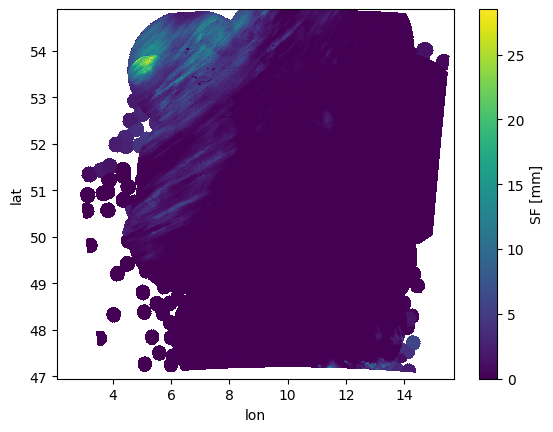

In [24]:
# Simple plot in lat-lon-space
dsg.SF.plot(x = "lon", y = "lat")

In [ ]:
# To make it CF conforming....

In [72]:
# RADKLIM DATASET
fpath2 = '/Users/icdc/Documents/NFDI/Kemeng/publishable_netcdf/data/raw/RW2017.002_200101/raa01-rw2017.002_10000-0101010050-dwd---bin'
ds_radklim = xr.open_dataset(fpath2, engine='radolan')
ds_radklim

TRIG


/Users/icdc/Documents/NFDI/Kemeng/myenv/venvNetcdf/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'RW' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset> Size: 4MB
Dimensions:  (y: 1100, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 8B 2001-01-01T00:50:00
  * y        (y) float64 9kB -4.758e+03 -4.757e+03 ... -3.66e+03 -3.659e+03
  * x        (x) float64 7kB -443.0 -442.0 -441.0 -440.0 ... 454.0 455.0 456.0
Data variables:
    RW       (y, x) float32 4MB ...
Attributes:
    radarid:            10000
    formatversion:      3
    radolanversion:     2.18.3
    radarlocations:     ['ham', 'ros', 'emd', 'han', 'umd', 'bln', 'ess', 'fl...
    moduleflag:         1
    reanalysisversion:  2017.002
    intervalunit:       0

In [73]:
radklim_grid = wrl.georef.get_radolan_grid(nrows = ds_radklim.sizes["y"],
                                           ncols = ds_radklim.sizes["x"],
                                           wgs84 = True,
                                           mode = "radolan")
dsg_radklim = ds_radklim.assign_coords({"lon": (["y", "x"], radklim_grid[..., 0]),
                                        "lat": (["y", "x"], radklim_grid[..., 1])})
dsg_radklim.info()

xarray.Dataset {
dimensions:
	y = 1100 ;
	x = 900 ;
	time = 1 ;

variables:
	float32 RW(y, x) ;
		RW:valid_min = 0 ;
		RW:valid_max = 4095 ;
		RW:standard_name = rainfall_rate ;
		RW:long_name = RW ;
		RW:unit = mm h-1 ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	float64 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
	float64 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
	float64 lon(y, x) ;
	float64 lat(y, x) ;

// global attributes:
	:radarid = 10000 ;
	:formatversion = 3 ;
	:radolanversion = 2.18.3 ;
	:radarlocations = ['ham', 'ros', 'emd', 'han', 'umd', 'bln', 'ess', 'fld', 'drs', 'neu', 'nhb', 'fra', 'eis', 'tur', 'muc', 'fbg'] ;
	:moduleflag = 1 ;
	:reanalysisversion = 2017.002 ;
	:intervalunit = 0 ;
}

In [75]:
dsg_radklim.RW.plot(x = "lon", y = "lat")

In [ ]:
# Merge multiple RADKLIM Data by Time
# --- Join multiple data arrays by dimension...